# Systems

In [1]:
import numpy as np
import scipy.signal

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cycler
import matplotlib.path as path
import matplotlib.patches as patches
from matplotlib.transforms import Bbox
import warnings
warnings.simplefilter('ignore')

from matplotlib.animation import FuncAnimation
import matplotlib.style
matplotlib.style.use('bauhaus')

np.random.seed(20200101)

colors = [_['color'] for _ in list(matplotlib.rcParams['axes.prop_cycle'])]

def figaspect(arg):
    # min/max sizes to respect when autoscaling.  If John likes the idea, they
    # could become rc parameters, for now they're hardwired.
    figsize_min = np.array((4.0, 2.0))  # min length for width/height
    figsize_max = np.array((16.0, 16.0))  # max length for width/height

    # Extract the aspect ratio of the array
    isarray = hasattr(arg, 'shape') and not np.isscalar(arg)
    if isarray:
        nr, nc = arg.shape[:2]
        arr_ratio = nr / nc
    else:
        arr_ratio = arg

    # Height of user figure defaults
    fig_width = matplotlib.rcParams['figure.figsize'][0]

    # New size for the figure, keeping the aspect ratio of the caller
    newsize = np.array((fig_width, fig_width *arr_ratio))
    #newsize = np.array((fig_height / arr_ratio, fig_height))

    # Sanity checks, don't drop either dimension below figsize_min
    newsize /= min(1.0, *(newsize / figsize_min))

    # Avoid humongous windows as well
    newsize /= max(1.0, *(newsize / figsize_max))

    # Finally, if we have a really funky aspect ratio, break it but respect
    # the min/max dimensions (we don't want figures 10 feet tall!)
    newsize = np.clip(newsize, figsize_min, figsize_max)
    return newsize

$$
\require{cancel}\notag%
\require{color}\notag%
$$

A **system** is any process which transforms one signal (the input, $x$) into another (the output, $y$).
Abstractly, we'll represent a system by some mathematical function $f$, so that we can say

$$
y = g(x).
$$

Note that systems generally depend on *the entire signal* $x$ and not just individual samples $x[n]$ in isolation!
This definition is **not equivalent** to defining a system sample-by-sample:

$$
{\color{#EC2830}y[n] = g(x[n])}\quad\quad\Leftarrow \text{not the same as } y = g(x)\text{!}\notag
$$

In the previous chapter, we saw several examples of systems implemented by *convolution*, 
where

$$
g(x) = h * x
$$

for some fixed impulse response $h$.
While this chapter is broadly concerned with analyzing convolutional systems, it will be helpful to broaden our view for a little while to think about different kinds of systems.
Looking at different kinds of systems will help us develop some intuition about what convolution can and cannot do.

## Examples

To warm up, we'll first work through a few example systems.

### Gain

After reading the previous chapter, the *gain* system should already be familiar.
All it does is scale each input sample $x$ by a fixed multiplicative factor $G$.
For example, $G=2$ would double the signal's amplitude, and $G=0$ would render it completely silent.
Mathematically, this is expressed as

$$
y[n] = G \cdot x[n],
$$

and in code, we could implement it as:
```python
def gain(x, G):
    # Note: when x is a numpy array, we could also multiply 
    # all samples by G at the same time.
    # This would replace the code below by the one-liner:
    #
    #    return G * x
    
    N = len(x)
    y = np.zeros(N)
    
    for n in range(N):
        y[n] = G * x[n]
        
    return y
```
This bit of code would define a new function `gain` which implements the system, and you could then call by saying
```python
y = gain(x, 2.0)  # Double amplitude
```

Having a system implemented by a self-contained function like this can make it easier to reason about and debug.
It can also help to isolate what parameters are needed to implement the system: in this case, just the input signal $x$ and the gain value $G$.

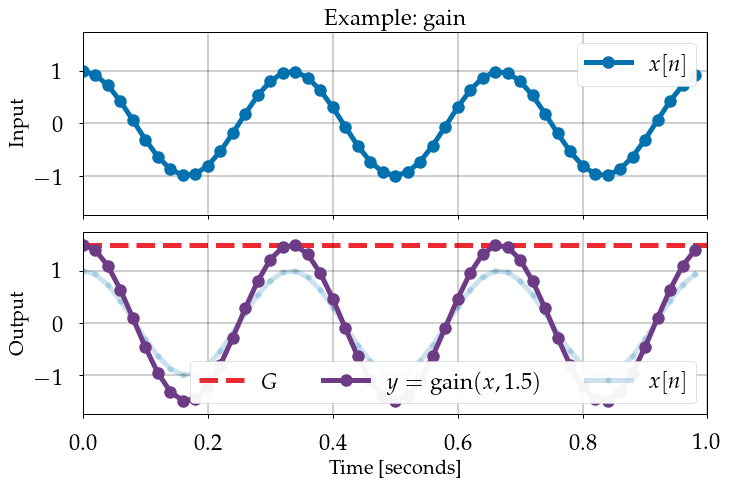

In [11]:
fs = 50
f0 = 3
duration = 1
times = np.arange(duration * fs) / fs
x = np.cos(2 * np.pi * f0 * times)

G = 1.5
y = G * x

fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=figaspect(2./3))
ax.plot(times, x, label='$x[n]$', marker='o', markersize=10)
ax.label_outer()
ax.legend(loc='upper right')
ax.set_ylabel('Input')
ax.set_title('Example: gain')

ax2.axhline(G, color=colors[1], linestyle='--', zorder=-1, label=r'$G$')
ax2.plot(times, y, label=r'$y = \mathrm{gain}(x, 1.5)$', 
           color=colors[4], marker='o', markersize=10)
ax2.plot(times, x, label='$x[n]$', marker='o', markersize=5, alpha=0.2, zorder=-1)
ax2.label_outer()
ax2.set_xlim([0, 1])
ax2.set_ylim([-1.75, 1.75])
ax2.set_xlabel('Time [seconds]')
ax2.legend(loc='lower right', ncol=3)
ax2.set_ylabel('Output');

### Clipping

A **clipping** system limits the output of a system so that it cannot be less than some minimum value $v_-$ or greater than a maximum value $v_+$.
In equations, this looks like:

$$
y[n] = \begin{cases}
v_+ & x[n] \geq v_+\\
v_- & x[n] \leq v_-\\
x[n] & \text{otherwise}
\end{cases}.
$$

Equivalently, in code this is expressed as:
```python
def clip(x, vmin, vmax):
    # This behavior is implemented by np.clip,
    # but we provide a full implementation
    # here for reference.
    
    N = len(x)
    y = np.zeros(N)
    
    for n in range(N):
        if x[n] >= vmax:
            y[n] = vmax
        elif x[n] <= vmin:
            y[n] = vmin
        else:
            y[n] = x[n]
    return y
```

Clipping is a key step of many *distortion* effects, leading to the distinctive sound of distorted electric guitar.
This is because clipping models what happens to amplifier circuits when pushed past their limits (overdriven): the amplifier is asked to produce a voltage higher than it's capable of, and the output signal saturates at its voltage limits.

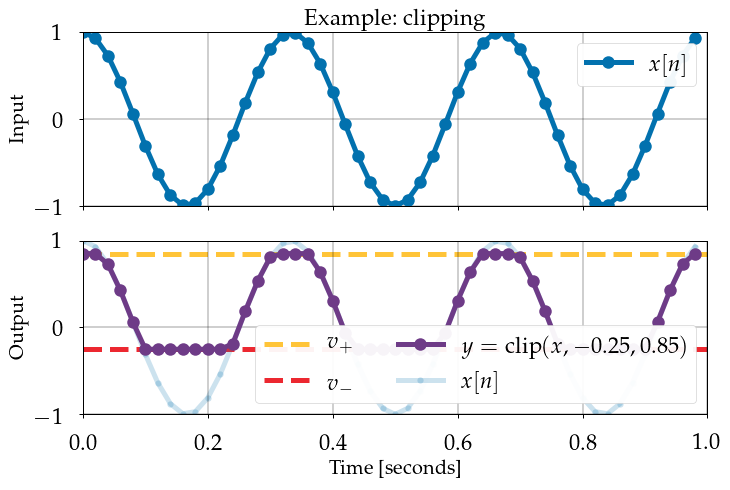

In [12]:
fs = 50
f0 = 3
duration = 1
times = np.arange(duration * fs) / fs
x = np.cos(2 * np.pi * f0 * times)
y = np.clip(x, -0.25, 0.85)

fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=figaspect(2./3))

ax.plot(times, x, label='$x[n]$', marker='o', markersize=10)
ax.label_outer()
ax.legend(loc='upper right')
ax.set_ylabel('Input')
ax.set_title('Example: clipping')


ax2.axhline(0.85, color=colors[2], linestyle='--', zorder=-1, label=r'$v_+$')
ax2.axhline(-0.25, color=colors[1], linestyle='--', zorder=-1, label=r'$v_-$')
ax2.plot(times, y, label=r'$y = \mathrm{clip}(x, -0.25, 0.85)$', 
           color=colors[4], marker='o', markersize=10)
ax2.plot(times, x, label='$x[n]$', marker='o', markersize=5, alpha=0.2, zorder=-1)
ax2.label_outer()
ax2.set_xlim([0, 1])
ax2.set_xlabel('Time [seconds]')
ax2.legend(loc='lower right', ncol=2)
ax2.set_ylabel('Output');

### Time-reversal

A *time-reversal* system does exactly what it sounds like: it plays the signal backward.
Mathematically, this is done by swapping the sample at index $n$ with the one at index $N-1-n$:

$$
y[n] = x[N - 1 - n]
$$

or in code,
```python
def reverse(x):
    # This could be equivalently done with the one-liner:
    #   return x[::-1]
    
    N = len(x)
    y = np.zeros(N)
    
    for n in range(N):
        y[n] = x[N-1-n]
    return y
```
Note that the previous two examples (gain and clipping) can operate independently on each sample, and do not need to know the entire signal at once to operate correctly.
However, this system needs to know the entire signal in advance.

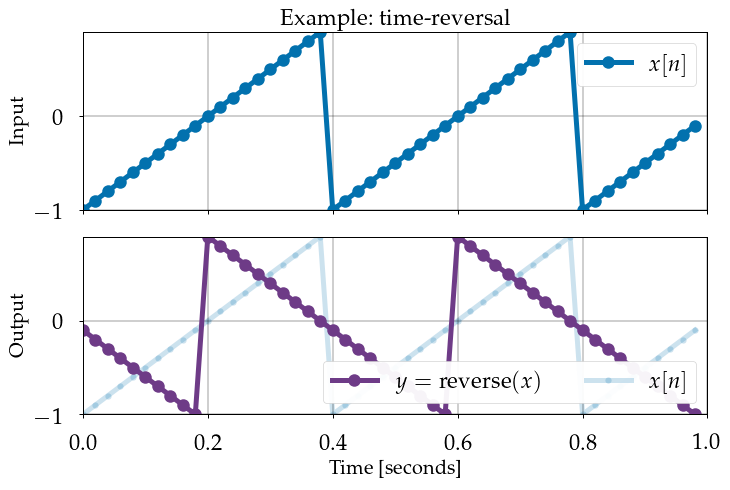

In [13]:
import scipy.signal

fs = 50
f0 = 2.5
duration = 1
times = np.arange(duration * fs) / fs
#x = np.cos(2 * np.pi * f0 * times)
x = scipy.signal.sawtooth(2 * np.pi * f0 * times)
y = x[::-1]



fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=figaspect(2./3))
ax.plot(times, x, label='$x[n]$', marker='o', markersize=10)
ax.label_outer()
ax.legend(loc='upper right')
ax.set_ylabel('Input')
ax.set_title('Example: time-reversal')

ax2.plot(times, y, label=r'$y = \mathrm{reverse}(x)$', 
           color=colors[4], marker='o', markersize=10)
ax2.plot(times, x, label='$x[n]$', marker='o', markersize=5, alpha=0.2, zorder=-1)
ax2.label_outer()
ax2.set_xlim([0, 1])
ax2.set_xlabel('Time [seconds]')
ax2.legend(loc='lower right', ncol=2)
ax2.set_ylabel('Output');

## Summary

In general, you can think of systems as *effects* to be applied to a signal.
Now that we've seen a few examples, we're ready to dive into what makes convolutional systems special.